In [46]:
from parser import OpenCorporaParser
from artm import ARTM
from tools import get_pointwise_mutual_information
import numpy as np
import scipy.sparse as sparse
from combined_smoothing_sparsing_regularizer import CombinedSmoothingSparsingRegularizer
from covariance_docs_regularizer import CovarianceDocsRegularizer
from covariance_topics_regularizer import CovarianceTopicsRegularizer
from elimination_of_insignificant_topics import EliminationOfInsignificantTopics
import matplotlib.pyplot as plt
import pickle

### Parse OpenCorpora

In [2]:
open_corpora_parser = OpenCorporaParser()

doc_term_matr, vocabulary, year, topic, close_word_pairs = open_corpora_parser.parse_open_corpora(
    path_to_corpus='annot.opcorpora.xml')

In [14]:
def get_words_list(vocabulary):
    return list(sorted(vocabulary, key=lambda word: vocabulary[word]))

In [15]:
word_in_doc_freqs = doc_term_matr.transpose()

In [16]:
word_in_doc_freqs_train = sparse.dok_matrix(word_in_doc_freqs[:, :1000])

In [17]:
words_count = word_in_doc_freqs.shape[0]
docs_count = word_in_doc_freqs_train.shape[1]

In [18]:
close_word_pairs_train = np.array(close_word_pairs)[:1000]
pmi = get_pointwise_mutual_information(word_in_doc_freqs_train, close_word_pairs_train)

In [19]:
def train_model(regularizers, regularizer_weights, topics_count = 100):

    model = ARTM(topics_count=topics_count, regularizers=regularizers, regularizer_weights=regularizer_weights)

    #TODO: plot convergence to show that EM is implemented correctly.

    train_result = model.train(word_in_doc_freqs=word_in_doc_freqs_train,
                               words_list=get_words_list(vocabulary),
                               iterations_count=20, verbose=True, 
                               pointwise_mutual_information=pmi)
    return train_result

In [40]:
def plot_score(model, model_name):
    likelihoods = model.loglikelihoods
    pmis = model.pmi_metrics
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(likelihoods)
    ax1.set_title('Convergence of likelihood for the {}'.format(model_name))
    ax1.set_xlabel('# iteration')
    ax1.set_ylabel('likelihood')
    ax2.plot(pmis)
    ax2.set_title('Convergence of PMI metrics for the {}'.format(model_name))
    ax2.set_xlabel('# iteration')
    ax2.set_ylabel('PMI metrics')
    
    plt.show()
    
    print('Resulting perplexity = {}'.format(model.get_train_perplexity()))
    print('Resulting PMI = {}'.format(model.get_pointwise_mutual_information_metric()))

### Baseline model

In [20]:
train_result_baseline = train_model(regularizers=[], regularizer_weights=[])

iter#1: loglike=-2916325.649455341 pmi_metric=-1.830197617222483
iter#2: loglike=-2909450.637940151 pmi_metric=-1.8230314822634353
iter#3: loglike=-2901502.82852189 pmi_metric=-1.8076897292746315
iter#4: loglike=-2891063.2018997404 pmi_metric=-1.7806162898247573
iter#5: loglike=-2876558.8735144106 pmi_metric=-1.7339076046292685
iter#6: loglike=-2856352.196995806 pmi_metric=-1.6557563069325818
iter#7: loglike=-2829719.852881333 pmi_metric=-1.5473369510414274
iter#8: loglike=-2797992.5657254886 pmi_metric=-1.4376318044999068
iter#9: loglike=-2764386.3219262892 pmi_metric=-1.3389573354998205
iter#10: loglike=-2732360.402180217 pmi_metric=-1.2584636913840006
iter#11: loglike=-2703967.236006446 pmi_metric=-1.2115192731636175
iter#12: loglike=-2679622.15210202 pmi_metric=-1.1840549635345619
iter#13: loglike=-2658875.4140420454 pmi_metric=-1.163642298481922
iter#14: loglike=-2641150.545445954 pmi_metric=-1.1587345675923455
iter#15: loglike=-2625951.737649706 pmi_metric=-1.163985192445129
iter

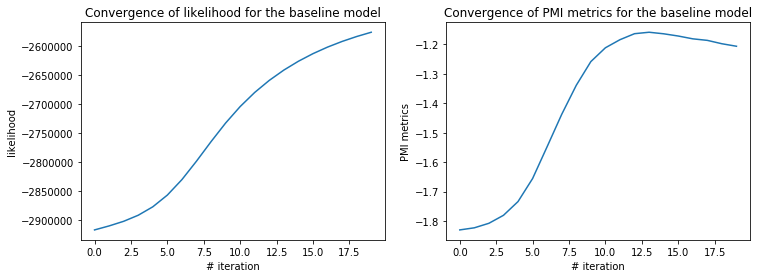

Resulting perplexity = 914.939000429074
Resulting PMI = -1.2063333543180088


In [41]:
plot_score(train_result_baseline, 'baseline model')

In [47]:
pickle.dump(train_result_baseline, open('baseline.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

### Adding regularizer

In [42]:
regularizers = [CovarianceTopicsRegularizer(tau=1.0, num_topics=100, num_words=words_count, num_docs=docs_count), 
                EliminationOfInsignificantTopics(tau=1.0, num_topics=100, 
                                                 num_words=words_count, num_docs=docs_count, 
                                                 word_in_doc_freqs=word_in_doc_freqs_train)              
               ]

regularizer_weights = [10., 100.]

In [43]:
train_result_regs = train_model(regularizers=regularizers, regularizer_weights=regularizer_weights)

iter#1: loglike=-2962575.6718092454 pmi_metric=-1.831679142676652
iter#2: loglike=-2955660.8198443446 pmi_metric=-1.822356809744268
iter#3: loglike=-2947599.487120808 pmi_metric=-1.8074984283740685
iter#4: loglike=-2936854.006499457 pmi_metric=-1.7790892448558167
iter#5: loglike=-2921597.9269793257 pmi_metric=-1.7300247053155797
iter#6: loglike=-2899855.8673426947 pmi_metric=-1.6535685991483218
iter#7: loglike=-2870884.0936935456 pmi_metric=-1.5425089349915853
iter#8: loglike=-2836666.1378288358 pmi_metric=-1.427599462791567
iter#9: loglike=-2801201.35968254 pmi_metric=-1.3259728122564878
iter#10: loglike=-2768182.5052866186 pmi_metric=-1.2621486912446622
iter#11: loglike=-2739483.675437773 pmi_metric=-1.2168954949569126
iter#12: loglike=-2715293.0227374556 pmi_metric=-1.1859477740265265
iter#13: loglike=-2694982.8408206794 pmi_metric=-1.18258768477055
iter#14: loglike=-2677813.024010404 pmi_metric=-1.1854978350484038
iter#15: loglike=-2663157.792728689 pmi_metric=-1.1885498018077645
i

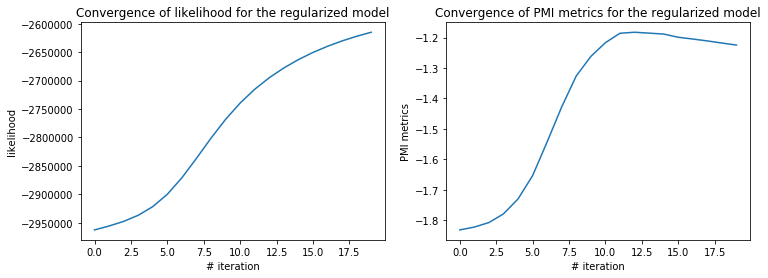

Resulting perplexity = 1014.5550566843847
Resulting PMI = -1.2247096542676785


In [44]:
plot_score(train_result_regs, 'regularized model')

In [48]:
pickle.dump(train_result_regs, open('regs.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)